### Chapter 14

### 14.1 Wide and Deep: introduction

For this Chapter I used a **p2.xlarge** in AWS. All the previous chapters were implemented using a c5.4xlarge instance.   

I will not extend myself too much explaining the model. This is simply because I wrote an entire [repo](https://github.com/jrzaurin/Wide-and-Deep-PyTorch) about it a while ago. So you could just go there and read. Nonetheless I will include here enough information to get us going. 

Details of the algorithm can be found in this [repo](https://github.com/tensorflow/models/tree/master/official/wide_deep), also in this [Google Blog post](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) and this [research paper](https://arxiv.org/abs/1606.07792). 

The model is a combination of a linear classifier/regressor for sparse features (Wide) plus a neural network classifier/regressor that receives the embeddings, and perhaps numerical features (Deep). The figure below, taken from [the tutorial](https://github.com/tensorflow/models/tree/master/official/wide_deep), is a good illustration on how the algorithm works.

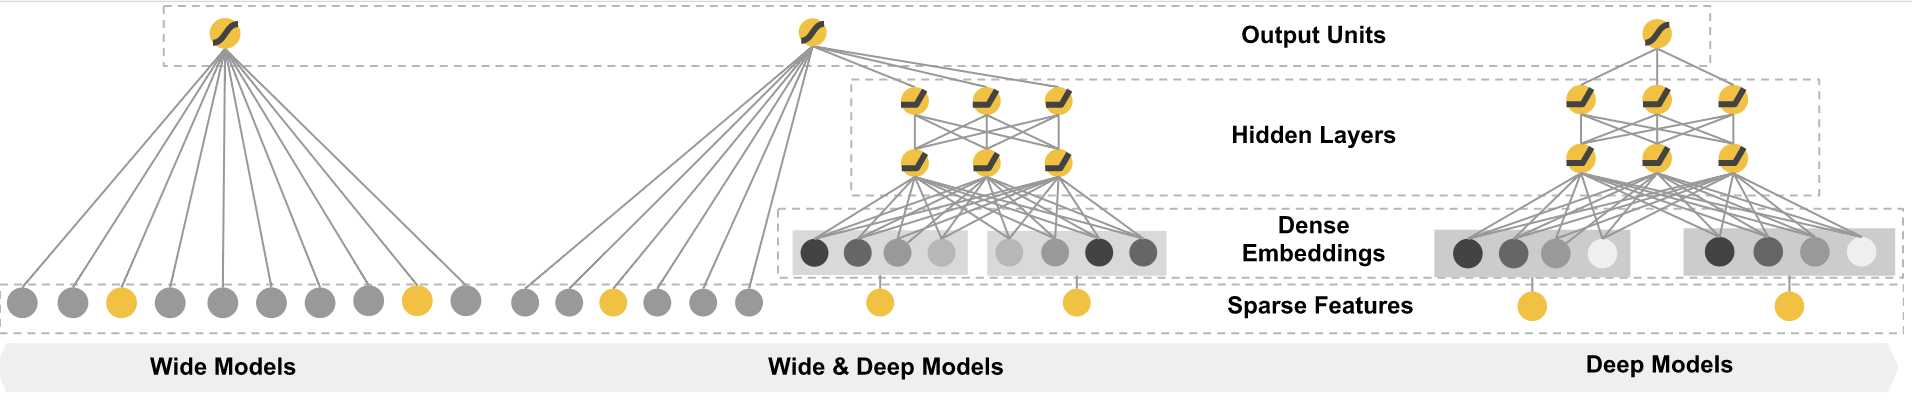

In [1]:
from IPython.display import Image
PATH = "/home/ubuntu/projects/RecoTour/datasets/Ponpare/data_processed/wide_deep/wide_deep.png"
Image(filename = PATH, width=1000, height=500)

A priori, "all" we have to do is:

1. Prepare the wide part
2. Prepare the deep part
3. Combine them

As one can imagine, there are a number of set-ups that can be used with this algorithm. For example:

1.  We can pass one-hot encoded features to the wide side of the model and embeddings for the categorical features to the deep side. 
2.  We can pass one-hot encoded features to the wide side of the model and embeddings for the categorical features, users and/or items to the deep side.
3. We can pass one-hot encoded features to the wide side of the model and embeddings for the categorical features, users and/or items and the numerical features to the deep side.

In other words, you can pass almost anything you want to the deep side of the architecture :) . 

For this exercise here we will use the following set up: 

1. Wide: one-hot encoded categorical features
2. Deep: numerical (aka continuous) plus categorical columns.

In reality it would be better to use at least user embeddings, but I thought about using the simplest set up to illustrate the model and include code for other set ups separately. Also, just mentioning that in this particular exercise, including coupon/item embeddings involves a mapping/similarity function between validation and training coupons, which complicates things. Nonetheless, two additional set ups (that do not work particularly better) including user and item embeddings are included in the `py_scripts` directory.

Nonetheless let me emphasize once more. In my opinion this dataset is not particularly suited for these type of algorithms. I think Wide and Deep algorithms (which I see as the little brother of [Neural Collaborative Filtering](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf)) are well suited for problems where the datasets are large, really complex or contain a lot of "latent information". For example, datasets that combine images, text and user behaviour would be ideal in this scenario. 

In the Figure above the Deep part of the model is simply a stack of dense layers. However, the Deep part can be anything we want. For example, if we would like to build a recommendation algorithm in the fashion space that utilises all the information at once (e.g. product descriptions, images and user behaviour) we could build an architecture with 3 branches: a RNN branch for the text, a CNN for the images and dense layers for user-item embeddings. All this fitted against a measure of interest. Through this process, the weights in all branches would be learned based on users's interest, rather than for example, purely the content of the image or the words in the description. 

In the future, I plan to use other datasets (like Amazon reviews) that hopefully will make a better use of these techniques. For now, let's move on

In [2]:
import numpy as np
import pandas as pd
import pickle
import os

from sklearn.model_selection import train_test_split

train_dir = "../datasets/Ponpare/data_processed/train"
valid_dir = "../datasets/Ponpare/data_processed/valid"
WD_DIR = "../datasets/Ponpare/data_processed/wide_deep"

train_coupons_path = os.path.join(train_dir, 'df_coupons_train_feat.p')
valid_coupons_path = os.path.join(valid_dir, 'df_coupons_valid_feat.p')

### 14.2 Data Preparation

### COUPONS

In [3]:
df_coupons_train_feat = pd.read_pickle(os.path.join(train_coupons_path))
df_coupons_valid_feat = pd.read_pickle(os.path.join(valid_coupons_path))
df_coupons_feat = df_coupons_train_feat.append(
    df_coupons_valid_feat,
    ignore_index=True)
drop_cols = [c for c in df_coupons_feat.columns
    if (('_cat' not in c) or ('method2' in c)) and (c!='coupon_id_hash')]
df_coupons_feat.drop(drop_cols, axis=1, inplace=True)
coupons_cat_cols = [c for c in df_coupons_feat.columns if c != "coupon_id_hash"]
df_coupons_feat.shape

(18980, 24)

### USERS

In [4]:
# user features
df_users_feat = pd.read_pickle(os.path.join(train_dir, 'df_user_train_feat.p'))

# let's add a categorical feature for age that will be used later for the "crossed_colums"
df_users_feat['age_cat'], age_bins = pd.qcut(df_users_feat['age'], q=4, labels=[0,1,2,3], retbins=True)

In [5]:
dict_of_mappings = pickle.load(open("../datasets/Ponpare/data_processed/dict_of_mappings.p", "rb"))
dict_of_mappings['age_cat'] = age_bins
dict_of_mappings

{'validperiod_cat': array([  0.,  89., 128., 177., 179.]),
 'dispperiod_cat': array([ 0,  2,  3,  4, 36]),
 'price_rate_cat': array([  0.,  50.,  60., 100.]),
 'catalog_price_cat': array([1.00e+00, 4.50e+03, 1.05e+04, 6.80e+05]),
 'discount_price_cat': array([     0.,   1980.,   3900., 100000.]),
 'capsule_text_cat': {'Food': 0,
  'Hair salon': 1,
  'Spa': 2,
  'Relaxation': 3,
  'Beauty': 4,
  'Nail and eye salon': 5,
  'Delivery service': 6,
  'Lesson': 7,
  'Gift card': 8,
  'Other': 9,
  'Leisure': 10,
  'Hotel': 11,
  'Japanese hotel': 12,
  'Vacation rental': 13,
  'Lodge': 14,
  'Resort inn': 15,
  'Guest house': 16,
  'Japanse guest house': 17,
  'Public hotel': 18,
  'Event': 19,
  'Web service': 20,
  'Health and medical': 21,
  'Class': 22,
  'Correspondence course': 23},
 'genre_name_cat': {'Food': 0,
  'Hair salon': 1,
  'Spa': 2,
  'Relaxation': 3,
  'Beauty': 4,
  'Nail and eye salon': 5,
  'Delivery service': 6,
  'Lesson': 7,
  'Gift card': 8,
  'Other coupon': 9,
  'L

In [6]:
# Users categorical and numerical columns
users_cat_cols = [c for c in df_users_feat.columns if c.endswith("_cat")]
users_num_cols = [c for c in df_users_feat.columns if
    (c not in users_cat_cols) and (c != "user_id_hash")]

# Normalize numerical columns
tmp_df = df_users_feat[users_num_cols]
tmp_df_norm = (tmp_df-tmp_df.min())/(tmp_df.max()-tmp_df.min())
df_users_feat.drop(users_num_cols, axis=1, inplace=True)
df_users_feat = pd.concat([tmp_df_norm, df_users_feat], axis=1)
del(tmp_df, tmp_df_norm)
df_users_feat.shape

(22624, 64)

### DEEP MODEL: embeddings plus continuous columns

How we process the features that will passed through the deep side of the model is up to you. Here I show one solution based on the number of levels that a categorical feature has

#### EMBEDDINGS

In [7]:
# DEEP
# let's decide whether to pass through the wide or deep side based on the
# levels of each categorical feature
coupon_cat_levels = {}
for c in coupons_cat_cols:
    n_levels = df_coupons_feat[c].nunique()
    coupon_cat_levels[c] = n_levels

user_cat_levels = {}
for c in users_cat_cols:
    n_levels = df_users_feat[c].nunique()
    user_cat_levels[c] = n_levels

user_cat_levels

{'pref_name_cat': 48,
 'sex_id_cat': 2,
 'top1_capsule_text_cat': 22,
 'top2_capsule_text_cat': 23,
 'top3_capsule_text_cat': 23,
 'top1_genre_name_cat': 14,
 'top2_genre_name_cat': 14,
 'top3_genre_name_cat': 14,
 'view_top1_capsule_text_cat': 22,
 'view_top2_capsule_text_cat': 22,
 'view_top3_capsule_text_cat': 23,
 'view_top1_genre_name_cat': 14,
 'view_top2_genre_name_cat': 14,
 'view_top3_genre_name_cat': 14,
 'view_top1_dayofweek_cat': 8,
 'view_top2_dayofweek_cat': 8,
 'top1_small_area_name_cat': 56,
 'top2_small_area_name_cat': 56,
 'top1_dayofweek_cat': 8,
 'top2_dayofweek_cat': 8,
 'age_cat': 4}

Before we move on let me just explain something around embeddings. An embedding layer is simply a tensor (some will say *"a representation"*) of dimensions $(M \times N)$ where $M$ can be the number of unique features in you categorical columns, the words in your corpus or **anything** you want to represent as embeddings, and $N$ is the dimension of each embedding. If you want to know more about embeddings there is A LOT of documentation online. I recently found [this course](https://developers.google.com/machine-learning/crash-course/embeddings/motivation-from-collaborative-filtering) that I think is very good.

For example, let's say that we have 20000 users, each with user id: $\{ id_1, id_2, id_3, ..., id_{20000} \}$ and we want to represent them as embeddings of 8 numbers. Then our embeddings layer/tensor would have dimensions 20000$\times$8.  When generating the layer we need to make sure that the mapping between the user ids and the integers that will be the indexes to the tensor is consistent, this is from 0 to 19999: $\{ id_1:0 , id_2:1, id_3:2, ..., id_{20000}:19999 \}$. If this does not happen when using `Pytorch` there are a number of implication al lower (CUDA) level, we will get a nasty CUDA-related error and the process will be immediately killed.

Therefore, let's make sure we will build the embeddings correctly. 

In [8]:
def consistency_test(df,cat_map):
    
    tests = []
    for c in df.columns:
        if c.endswith("_cat"):            
            vals = list(df[c].unique())

            # length is identical:
            lengh_test = (len(vals) == cat_map[c])
            
            # and vals is a sequence of consecutive numbers
            sequence_test = (sorted(vals) == list(range(min(vals), max(vals)+1)))

            tests.append([lengh_test,sequence_test])

            print([lengh_test,sequence_test], c)

    return(np.all(tests))

In [9]:
consistency_test(df_coupons_feat, coupon_cat_levels)

[True, True] usable_date_mon_cat
[True, True] usable_date_tue_cat
[True, True] usable_date_wed_cat
[True, True] usable_date_thu_cat
[True, True] usable_date_fri_cat
[True, True] usable_date_sat_cat
[True, True] usable_date_sun_cat
[True, True] usable_date_holiday_cat
[True, True] usable_date_before_holiday_cat
[True, True] validperiod_method1_cat
[True, True] validfrom_method1_cat
[True, True] validend_method1_cat
[True, True] dispfrom_cat
[True, True] dispend_cat
[True, True] dispperiod_cat
[True, True] price_rate_cat
[True, True] catalog_price_cat
[True, True] discount_price_cat
[True, True] capsule_text_cat
[True, True] genre_name_cat
[True, True] large_area_name_cat
[True, True] ken_name_cat
[True, True] small_area_name_cat


True

In [10]:
consistency_test(df_users_feat, user_cat_levels)

[True, True] pref_name_cat
[True, True] sex_id_cat
[True, False] top1_capsule_text_cat
[True, False] top2_capsule_text_cat
[True, False] top3_capsule_text_cat
[True, True] top1_genre_name_cat
[True, True] top2_genre_name_cat
[True, True] top3_genre_name_cat
[True, False] view_top1_capsule_text_cat
[True, False] view_top2_capsule_text_cat
[True, False] view_top3_capsule_text_cat
[True, True] view_top1_genre_name_cat
[True, True] view_top2_genre_name_cat
[True, True] view_top3_genre_name_cat
[True, True] view_top1_dayofweek_cat
[True, True] view_top2_dayofweek_cat
[True, True] top1_small_area_name_cat
[True, True] top2_small_area_name_cat
[True, True] top1_dayofweek_cat
[True, True] top2_dayofweek_cat
[True, True] age_cat


False

It looks like we have a problem with `capsule_text` related features, let's have a closer look: 

In [11]:
sorted(df_users_feat.top1_capsule_text_cat.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 24]

In [12]:
print(dict_of_mappings['top1_capsule_text_cat'])

{'Food': 0, 'Hair salon': 1, 'Spa': 2, 'Relaxation': 3, 'Beauty': 4, 'Nail and eye salon': 5, 'Delivery service': 6, 'Lesson': 7, 'Gift card': 8, 'Other': 9, 'Leisure': 10, 'Hotel': 11, 'Japanese hotel': 12, 'Vacation rental': 13, 'Lodge': 14, 'Resort inn': 15, 'Guest house': 16, 'Japanse guest house': 17, 'Public hotel': 18, 'Event': 19, 'Web service': 20, 'Health and medical': 21, 'Class': 22, 'Correspondence course': 23, 'NAN': 24}


In the dataframe we have 22 different values while when we build the features chapters ago we there were 25 different possible values for this feature. Why are `Public hotel` (index 18), `Class` (index 22) and `Correspondence course` (index 23) missing? well, simply because coupons of those categories were never purchased or viewed during training. 

Remember that we want to be able to recover the embeddings. Therefore these will be generated with the dictionary `dict_of_mappings`, which stores all the required information. Overall, this simply means that the embeddings for `top1_capsule_text_cat` will be a matrix of dimensions (25 $\times$ n_emb) and the embedding for `Public hotel`, `Class` and `Correspondence course` will never be learned (will remain with their initial values). Not a big deal.

Finally note that `NAN` is treated as another category. Remember that this is the approach I chose, but life is full of options, so feel free to choose anything you think or know will perform better. Let's move on.

Which features will be represented as embeddings and the embedding dimensions will be decided based on the number of levels. The numbers in the cell below are rather random and a process optimization process should include them. 

In [13]:
# if a categorical feature has more than 10 levels we will use embeddings. The
# dimension of the embeddings will depends on the number of levels
embeddings_cols=[]
for col,nl in coupon_cat_levels.items():
    if (nl >= 10) and (nl <=20): embeddings_cols.append((col, 6))
    elif (nl >= 10) and (nl > 20): embeddings_cols.append((col, 8))
for col,nl in user_cat_levels.items():
    if (nl >= 10) and (nl <=20): embeddings_cols.append((col, 6))
    elif (nl >= 10) and (nl > 20): embeddings_cols.append((col, 8))
embeddings_col_name = [c[0] for c in embeddings_cols]
embeddings_col_name

['capsule_text_cat',
 'genre_name_cat',
 'ken_name_cat',
 'small_area_name_cat',
 'pref_name_cat',
 'top1_capsule_text_cat',
 'top2_capsule_text_cat',
 'top3_capsule_text_cat',
 'top1_genre_name_cat',
 'top2_genre_name_cat',
 'top3_genre_name_cat',
 'view_top1_capsule_text_cat',
 'view_top2_capsule_text_cat',
 'view_top3_capsule_text_cat',
 'view_top1_genre_name_cat',
 'view_top2_genre_name_cat',
 'view_top3_genre_name_cat',
 'top1_small_area_name_cat',
 'top2_small_area_name_cat']

In [14]:
# As I mentioned, we want to recover the embeddings, so we need an encoding dictonary (dict_of_mappings)
encoding_dict = dict_of_mappings.copy()

Let's define the list of tuples that will be passed to our wide and deep model (see [my repo](https://github.com/jrzaurin/Wide-and-Deep-PyTorch/blob/master/demo1_prepare_data.ipynb) for full details on data preparation and why this tuples make our life eas...ier)

In [15]:
embeddings_input = []
for (col, n_emb) in embeddings_cols:
    embeddings_input.append((col, len(encoding_dict[col]), n_emb))
embeddings_input

[('capsule_text_cat', 24, 8),
 ('genre_name_cat', 13, 6),
 ('ken_name_cat', 47, 8),
 ('small_area_name_cat', 55, 8),
 ('pref_name_cat', 48, 8),
 ('top1_capsule_text_cat', 25, 8),
 ('top2_capsule_text_cat', 25, 8),
 ('top3_capsule_text_cat', 25, 8),
 ('top1_genre_name_cat', 14, 6),
 ('top2_genre_name_cat', 14, 6),
 ('top3_genre_name_cat', 14, 6),
 ('view_top1_capsule_text_cat', 25, 8),
 ('view_top2_capsule_text_cat', 25, 8),
 ('view_top3_capsule_text_cat', 25, 8),
 ('view_top1_genre_name_cat', 14, 6),
 ('view_top2_genre_name_cat', 14, 6),
 ('view_top3_genre_name_cat', 14, 6),
 ('top1_small_area_name_cat', 56, 8),
 ('top2_small_area_name_cat', 56, 8)]

#### CONTINUOUS COLUMNS

In [16]:
# continuous_cols
continuous_cols = users_num_cols.copy()

Deep side comprised by embeddings and continuos columns

In [17]:
deep_cols = embeddings_col_name+continuous_cols

### WIDE MODEL

In [18]:
wide_cols = [c for c in coupons_cat_cols+users_cat_cols if c not in embeddings_col_name]
wide_cols

['usable_date_mon_cat',
 'usable_date_tue_cat',
 'usable_date_wed_cat',
 'usable_date_thu_cat',
 'usable_date_fri_cat',
 'usable_date_sat_cat',
 'usable_date_sun_cat',
 'usable_date_holiday_cat',
 'usable_date_before_holiday_cat',
 'validperiod_method1_cat',
 'validfrom_method1_cat',
 'validend_method1_cat',
 'dispfrom_cat',
 'dispend_cat',
 'dispperiod_cat',
 'price_rate_cat',
 'catalog_price_cat',
 'discount_price_cat',
 'large_area_name_cat',
 'sex_id_cat',
 'view_top1_dayofweek_cat',
 'view_top2_dayofweek_cat',
 'top1_dayofweek_cat',
 'top2_dayofweek_cat',
 'age_cat']

We can also use crossed columns. Quoting the paper: *"A cross product transformation (e.g., AND(gender=female, language=en)) is 1 if and only if the constituent features (gender=female and language=en) are all 1, and 0 otherwise"*. 

For the example here, it is a bit inconvenient to mix coupon and user features, so I will focus on user features here.

In [19]:
cross_cols = (['sex_id_cat','top1_genre_name_cat'], ['age_cat', 'top1_genre_name_cat'])

def paste_cols(row, cols):
    vals = []
    for c in cols:
        vals.append(str(row[c]))
    return '-'.join(vals)

crossed_columns = []
for cols in cross_cols:
    colname = '_'.join(cols)
    df_users_feat[colname] = df_users_feat.apply(lambda x: paste_cols(x, cols), axis=1)
    crossed_columns.append(colname)
    wide_cols+=[colname]
df_users_feat[['sex_id_cat_top1_genre_name_cat']].head()

,sex_id_cat_top1_genre_name_cat
0,0-6
1,0-0
2,1-6
3,1-9
4,1-0


Up to here we have the wide and deep columns that are in themselves comprised by:
deep = embeddings + continuous
wide = wide + crossed_columns

Let's now build the dataset's themselves

### Train Dataset

In [20]:
# TRAIN DATASET
df_interest = pd.read_pickle(os.path.join(train_dir, 'df_interest.p'))
df_interest.drop('recency_factor', axis=1, inplace=True)
df_train = pd.merge(df_interest, df_coupons_feat, on = 'coupon_id_hash')
df_train = pd.merge(df_train, df_users_feat, on='user_id_hash')
df_train.shape

(1560464, 91)

### Validatio Dataset

In [21]:
# Read the interactions during validation
interactions_valid_dict = pickle.load(
    open("../datasets/Ponpare/data_processed/valid/interactions_valid_dict.p", "rb"))

In [22]:
left = pd.DataFrame({'user_id_hash':list(interactions_valid_dict.keys())})
left['key'] = 0
right = df_coupons_valid_feat[['coupon_id_hash']]
right['key'] = 0
df_valid = (pd.merge(left, right, on='key', how='outer')
    .drop('key', axis=1))
df_valid = pd.merge(df_valid, df_users_feat, on='user_id_hash')
df_valid = pd.merge(df_valid, df_coupons_feat, on = 'coupon_id_hash')

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Train Data Split

I will split our training dataset into train/valid and **I will refer to the existing validation (the cartesian product between validation coupons and training users) as test**. Hope is clear. 

As always, just remember one hot encoding must be done in one go.

In [23]:
# One hot encoding must be done all at once to ensure same number of
# dimensions through all datasets
df_train['set_type']  = 0
df_valid['set_type']  = 1
tmpdf = pd.concat([df_train,df_valid], ignore_index=True)
tmpdf_dummy = pd.get_dummies(tmpdf, columns=wide_cols)

df_train_wd = (tmpdf_dummy[tmpdf_dummy.set_type == 0]
    .drop('set_type', axis=1))
df_valid_wd = (tmpdf_dummy[tmpdf_dummy.set_type == 1]
    .drop('set_type', axis=1))
del(tmpdf_dummy)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [24]:
# not that fat...
df_train_wd.shape

(1560464, 276)

In [25]:
wide_dummy_cols = [c for c in df_train_wd.columns
    if c not in deep_cols+['interest','user_id_hash','coupon_id_hash']]
wide_dummy_cols[:10]

['usable_date_mon_cat_0',
 'usable_date_mon_cat_1',
 'usable_date_mon_cat_2',
 'usable_date_mon_cat_3',
 'usable_date_tue_cat_0',
 'usable_date_tue_cat_1',
 'usable_date_tue_cat_2',
 'usable_date_tue_cat_3',
 'usable_date_wed_cat_0',
 'usable_date_wed_cat_1']

In [26]:
df_tr, df_val = train_test_split(df_train_wd, test_size=0.25, random_state=1981)
y_train, y_valid = df_tr.interest.values, df_val.interest.values

In [27]:
# deep side history
df_tr_deep, df_val_deep, df_test_deep = df_tr[deep_cols], df_val[deep_cols], df_valid_wd[deep_cols]

# This we'll need it for the model (again have a look in my github account to the wide and deep repo in pytorch)
deep_column_idx = {k:v for v,k in enumerate(df_tr_deep.columns)}

# wide side history
df_tr_wide, df_val_wide, df_test_wide = df_tr[wide_dummy_cols], df_val[wide_dummy_cols], df_valid_wd[wide_dummy_cols]

# To matrices
X_train_wide, X_train_deep = df_tr_wide.values, df_tr_deep.values
X_valid_wide, X_valid_deep = df_val_wide.values, df_val_deep.values
X_test_wide, X_test_deep   = df_test_wide.values, df_test_deep.values

Save all the set up to a dictionary for later use (very convenient)

In [29]:
# SAVE TO A DICT
wd_dataset = {}
wd_dataset['train_dataset'] = {}
wd_dataset['train_dataset']['wide'], \
wd_dataset['train_dataset']['deep'], \
wd_dataset['train_dataset']['target'] = X_train_wide, X_train_deep, y_train
wd_dataset['valid_dataset'] = {}
wd_dataset['valid_dataset']['wide'], \
wd_dataset['valid_dataset']['deep'], \
wd_dataset['valid_dataset']['target'] = X_valid_wide, X_valid_deep, y_valid
wd_dataset['test_dataset'] = {}
wd_dataset['test_dataset']['wide'], \
wd_dataset['test_dataset']['deep'] = X_test_wide, X_test_deep
wd_dataset['embeddings_input']  = embeddings_input
wd_dataset['deep_column_idx'] = deep_column_idx
wd_dataset['encoding_dict'] = encoding_dict
wd_dataset['continuous_cols'] = continuous_cols
pickle.dump(wd_dataset, open(os.path.join(WD_DIR, "wd_dataset.p"), "wb"))

In [31]:
interactions_dict = {}
interactions_dict['true_valid_interactions'] = interactions_valid_dict
interactions_dict['all_valid_interactions'] = df_valid_wd[['user_id_hash', 'coupon_id_hash']]
pickle.dump(interactions_dict, open(os.path.join(WD_DIR, "interactions_dict.p"), "wb"))